In [0]:
import tensorflow as tf
import tensorflow.keras as keras
keras.__version__

'2.3.0-tf'

In [0]:
print("GPU Available: ", tf.test.is_gpu_available())

print("Tensorflow Version: ", tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
Tensorflow Version:  2.2.0-rc3


In [0]:
#check GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as img 
import cv2 as cv

In [0]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

In [0]:
Trainimage_path='/content/gdrive/My\ Drive/Developer/FireProject/FireVideo/binary_dataset/train'
Validimage_path='/content/gdrive/My\ Drive/Developer/FireProject/FireVideo/binary_dataset/validation'

In [0]:
!ls {Trainimage_path}

negatives  positives


In [0]:
Trainimage_positive_path = os.path.join(Trainimage_path, 'positives')

In [0]:
# reading jpg image file via opencv
filepath=os.path.join(Trainimage_positive_path, '00910.jpg')
!cp {filepath} .

In [0]:
print(filepath)

/content/gdrive/My\ Drive/Developer/FireProject/FireVideo/binary_dataset/train/positives/00910.jpg


(-0.5, 1919.5, 1079.5, -0.5)

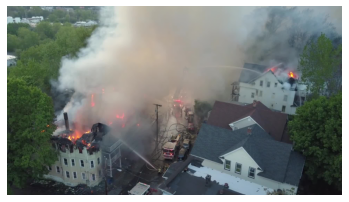

In [0]:
img = tf.keras.preprocessing.image.load_img('./00910.jpg')#, target_size=(IMAGE_SIZE, IMAGE_SIZE))
#returns A PIL Image instance, 00064.jpg 

plt.imshow(img)
plt.axis('off')

In [0]:
img.size

(1920, 1080)

In [0]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename, img_sizeh, img_sizew):
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [img_sizeh, img_sizew], preserve_aspect_ratio=True)
  return image

def show(image, title):
  plt.figure()
  plt.imshow(image)
  plt.title(title)
  plt.axis('off')

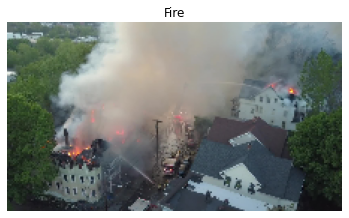

In [0]:
image1=parse_image('./00910.jpg', 224, 224)
show(image1, 'Fire')

In [0]:
image1.shape #[new_height, new_width, channels]

TensorShape([126, 224, 3])

(-0.5, 223.5, 223.5, -0.5)

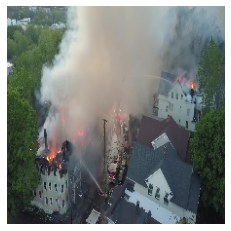

In [0]:
IMAGE_SIZE = 224
img = tf.keras.preprocessing.image.load_img('/content/gdrive/My Drive/Developer/FireProject/FireVideo/binary_dataset/train/positives/00910.jpg', target_size=(IMAGE_SIZE, IMAGE_SIZE))
#returns A PIL Image instance, 00064.jpg 

plt.imshow(img)
plt.axis('off')

#Create the dataset

---



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE=224
# All images will be rescaled by 1./255 (to 0-1 range)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Trainimage_path='/content/gdrive/My Drive/Developer/FireProject/FireVideo/binary_dataset/train'
Validimage_path='/content/gdrive/My Drive/Developer/FireProject/FireVideo/binary_dataset/validation'

train_generator= train_datagen.flow_from_directory(
        # This is the target directory
        Trainimage_path,
        # All images will be resized to 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1826 images belonging to 2 classes.


In [0]:
validation_generator = test_datagen.flow_from_directory(
        directory = Validimage_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        class_mode='binary')

Found 191 images belonging to 2 classes.


In [0]:
# Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(validation_generator))
val_image_batch.shape

(16, 224, 224, 3)

In [0]:
class_names = ['Fire', 'No Fire']

In [0]:
val_label_batch[0]

0.0

In [0]:
print (train_generator.class_indices)

{'negatives': 0, 'positives': 1}


In [0]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Negatives' 'Positives']


In [0]:
dataset_labels[int(val_label_batch[0])]

'Negatives'

In [0]:
# Learn about dataset labels
labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

In [0]:
!cat labels.txt

negatives
positives

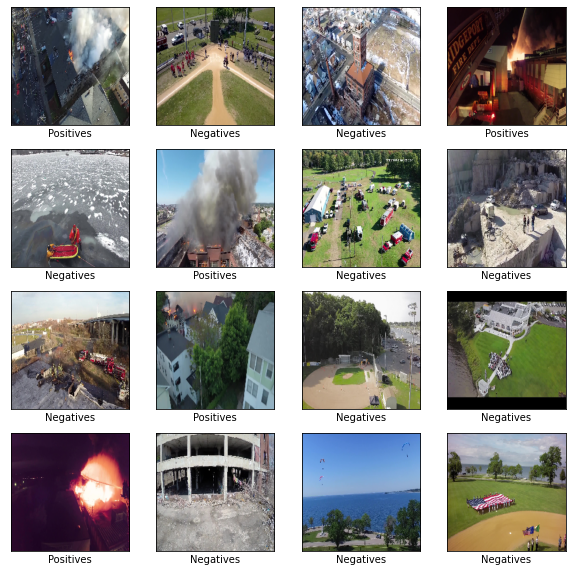

In [0]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_image_batch[i], cmap=plt.cm.binary)
    plt.xlabel(dataset_labels[int(val_label_batch[i])])
plt.show()

# Create Model 0

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.03), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [0]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(validation_generator.samples/validation_generator.batch_size)

In [0]:
history = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=val_steps_per_epoch)

Epoch 1/10
115/115 [==============================] - 871s 8s/step - loss: 1.0451 - acc: 0.7021 - val_loss: 0.7208 - val_acc: 0.6911
Epoch 2/10
115/115 [==============================] - 48s 415ms/step - loss: 0.5033 - acc: 0.8450 - val_loss: 0.3946 - val_acc: 0.8953
Epoch 3/10
115/115 [==============================] - 48s 414ms/step - loss: 0.4362 - acc: 0.8472 - val_loss: 0.3743 - val_acc: 0.8796
Epoch 4/10
115/115 [==============================] - 48s 418ms/step - loss: 0.3838 - acc: 0.8631 - val_loss: 0.3531 - val_acc: 0.8848
Epoch 5/10
115/115 [==============================] - 48s 417ms/step - loss: 0.3623 - acc: 0.8751 - val_loss: 0.3374 - val_acc: 0.9005
Epoch 6/10
115/115 [==============================] - 48s 416ms/step - loss: 0.3613 - acc: 0.8855 - val_loss: 0.7313 - val_acc: 0.7382
Epoch 7/10
115/115 [==============================] - 48s 419ms/step - loss: 0.3389 - acc: 0.8899 - val_loss: 0.3399 - val_acc: 0.8953
Epoch 8/10
115/115 [==============================] - 48s

In [0]:
def showTrainHistory(hist):
  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fighandle = plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  return fighandle

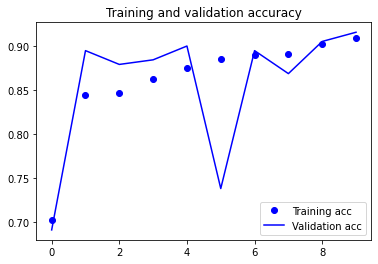

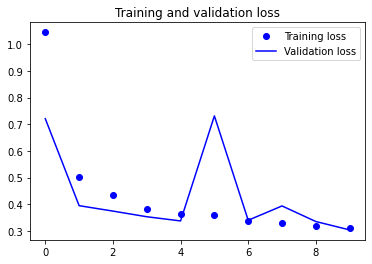

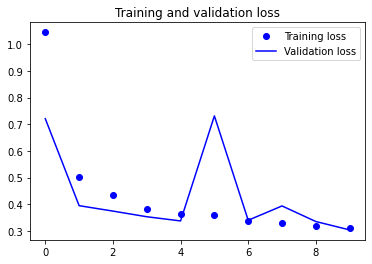

In [0]:
showTrainHistory(history)

# Convert

In [0]:
!mkdir -p saved_model
FIRE_SAVED_MODEL0 = './saved_model/model0_fire'
model.save(FIRE_SAVED_MODEL0) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_model/model0_fire/assets


In [0]:
converter = tf.lite.TFLiteConverter.from_saved_model(FIRE_SAVED_MODEL0)

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT] #Post-training quantization

In [0]:
tflite_quant_model = converter.convert()
open("convertedfire_model0.tflite", "wb").write(tflite_quant_model)

2869080

In [0]:
!cp convertedfire_model0.tflite '/content/gdrive/My Drive/Colab Notebooks/'

In [0]:
!pip install --upgrade coremltools

     |████████████████████████████████| 3.4MB 10.4MB/s 


In [0]:
!pip install -U tfcoreml

     |████████████████████████████████| 51kB 3.8MB/s 


ref: https://github.com/apple/coremltools/blob/master/examples/neural_network_inference/tensorflow_converter/Tensorflow_2/tf_keras_fashion_mnist.ipynb

In [0]:
keras_model = model
model_file = './model_new0.h5'
keras_model.save(model_file)

In [0]:
new_model = tf.keras.models.load_model('./model_new0.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 86528)            

ref: https://github.com/apple/coremltools/blob/master/examples/NeuralNetworkGuide.md#TensorFlow-conversion

In [0]:
FIRE_SAVED_MODEL0 = './saved_model/model0_fire'

In [0]:
import tfcoreml
model = tfcoreml.convert(FIRE_SAVED_MODEL0,
                         mlmodel_path='./model0.mlmodel',
                         input_name_shape_dict={'input_1': (1, 224, 224, 3)},
                         output_feature_names=['Identity'],
                         minimum_ios_deployment_target='13')

0 assert nodes deleted
10 nodes deleted
0 nodes deleted
0 nodes deleted
[Op Fusion] fuse_bias_add() deleted 10 nodes.
2 identity nodes deleted
5 disconnected nodes deleted
[SSAConverter] Converting function main ...
[SSAConverter] [1/18] Converting op type: 'Placeholder', name: 'input_1', output_shape: (1, 224, 224, 3).
[SSAConverter] [2/18] Converting op type: 'Const', name: 'sequential_2/flatten_2/Const', output_shape: (2,).
[SSAConverter] [3/18] Converting op type: 'Transpose', name: 'input_1_to_nchw', output_shape: (1, 3, 224, 224).
[SSAConverter] [4/18] Converting op type: 'Conv2D', name: 'sequential_2/conv2d_7/Conv2D', output_shape: (1, 32, 222, 222).
[SSAConverter] [5/18] Converting op type: 'Relu', name: 'sequential_2/conv2d_7/Relu', output_shape: (1, 32, 222, 222).
[SSAConverter] [6/18] Converting op type: 'MaxPool', name: 'sequential_2/max_pooling2d_7/MaxPool', output_shape: (1, 32, -1, -1).
[SSAConverter] [7/18] Converting op type: 'Conv2D', name: 'sequential_2/conv2d_8/Conv

In [0]:
!cp -r ./saved_model/ '/content/gdrive/My Drive/Colab Notebooks/'

In [0]:
!cp model0.mlmodel '/content/gdrive/My Drive/Colab Notebooks/'

# Create Model 1

In [0]:
!pip install tensorflow_hub
import tensorflow_hub as hub
print("Hub version: ", hub.__version__)

Hub version:  0.8.0


In [0]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)

In [0]:
train_generator.num_classes

2

In [0]:
#num_classes =train_generator.num_classes
from keras import regularizers
# Define a simple sequential model
def create_model():
  model_new = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dropout(0.5),#0.4
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.03), activation='relu'),#32 0.01
    tf.keras.layers.Dense(1)
  ])
  model_new.compile(
    optimizer='adam', 
    loss = 'binary_crossentropy',#tf.keras.losses.BinaryCrossentropy,
    metrics=['accuracy'])

  return model_new

# Create a basic model instance
model1 = create_model()

In [0]:
!rm -r training_1

In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    #verbose=1, 
    save_weights_only=True,
    save_freq=2)

In [0]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(validation_generator.samples/validation_generator.batch_size)

In [0]:
steps_per_epoch

115.0

In [0]:
EPOCHS = 10
hist = model1.fit(train_generator,
                 steps_per_epoch=steps_per_epoch, #the default NULL is equal to the number of samples in your dataset divided by the batch size
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                 validation_steps=val_steps_per_epoch,
                 callbacks=[cp_callback])

Epoch 1/10
115/115 [==============================] - 53s 459ms/step - loss: 4.2097 - accuracy: 0.8532 - val_loss: 2.8002 - val_accuracy: 0.9058
Epoch 2/10
  1/115 [..............................] - ETA: 0s - loss: 1.9615 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.144696). Check your callbacks.


115/115 [==============================] - 53s 459ms/step - loss: 2.9956 - accuracy: 0.9053 - val_loss: 2.1316 - val_accuracy: 0.9634
Epoch 3/10
115/115 [==============================] - 52s 453ms/step - loss: 2.7214 - accuracy: 0.9124 - val_loss: 1.9840 - val_accuracy: 0.9634
Epoch 4/10
  1/115 [..............................] - ETA: 0s - loss: 2.3904 - accuracy: 0.9375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.119901). Check your callbacks.


115/115 [==============================] - 53s 463ms/step - loss: 2.0976 - accuracy: 0.9376 - val_loss: 1.6713 - val_accuracy: 0.9529
Epoch 5/10
115/115 [==============================] - 53s 459ms/step - loss: 2.0566 - accuracy: 0.9370 - val_loss: 1.5307 - val_accuracy: 0.9581
Epoch 6/10
  1/115 [..............................] - ETA: 0s - loss: 1.0975 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.123449). Check your callbacks.


115/115 [==============================] - 53s 460ms/step - loss: 1.8468 - accuracy: 0.9392 - val_loss: 1.9112 - val_accuracy: 0.9372
Epoch 7/10
115/115 [==============================] - 53s 458ms/step - loss: 1.7286 - accuracy: 0.9392 - val_loss: 1.4356 - val_accuracy: 0.9529
Epoch 8/10
  1/115 [..............................] - ETA: 0s - loss: 0.9302 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.133919). Check your callbacks.


115/115 [==============================] - 54s 467ms/step - loss: 1.4927 - accuracy: 0.9562 - val_loss: 1.1294 - val_accuracy: 0.9791
Epoch 9/10
115/115 [==============================] - 53s 458ms/step - loss: 1.4351 - accuracy: 0.9491 - val_loss: 1.0223 - val_accuracy: 0.9791
Epoch 10/10
  1/115 [..............................] - ETA: 0s - loss: 2.7159 - accuracy: 0.8125WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.123418). Check your callbacks.


115/115 [==============================] - 53s 463ms/step - loss: 2.4648 - accuracy: 0.8762 - val_loss: 3.0139 - val_accuracy: 0.8429


In [0]:
hist.history

{'accuracy': [0.8532311320304871,
  0.9052574038505554,
  0.9123767614364624,
  0.9375684261322021,
  0.9370208382606506,
  0.939211368560791,
  0.939211368560791,
  0.9561883807182312,
  0.9490690231323242,
  0.8762322068214417],
 'loss': [4.209670066833496,
  2.9956209659576416,
  2.7214033603668213,
  2.097600221633911,
  2.056626558303833,
  1.846795916557312,
  1.7285792827606201,
  1.49271821975708,
  1.4351152181625366,
  2.464789628982544],
 'val_accuracy': [0.9057591557502747,
  0.963350772857666,
  0.963350772857666,
  0.9528796076774597,
  0.9581151604652405,
  0.9371727705001831,
  0.9528796076774597,
  0.9790576100349426,
  0.9790576100349426,
  0.8429319262504578],
 'val_loss': [2.800201654434204,
  2.131552219390869,
  1.9840000867843628,
  1.6712970733642578,
  1.5306767225265503,
  1.9111546277999878,
  1.435613751411438,
  1.1294242143630981,
  1.0223275423049927,
  3.013880491256714]}

In [0]:
def showTrainHistory(hist):
  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(len(acc))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fighandle = plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  return fighandle

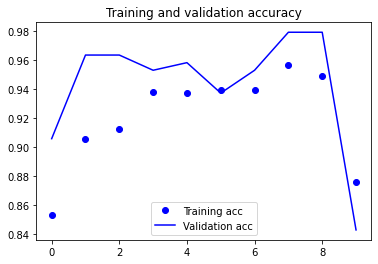

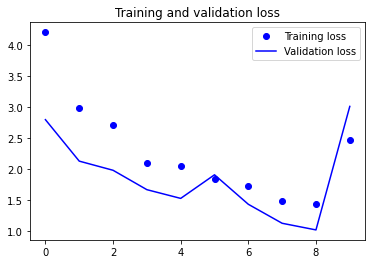

In [0]:
fighandle = showTrainHistory(hist)

In [0]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_1/cp-0010.ckpt'

In [0]:
# Create a new model instance
model_new1 = create_model()

# Load the previously saved weights
model_new1.load_weights(latest)

In [0]:
!rm -r training_2

rm: cannot remove 'training_2': No such file or directory


In [0]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path2 = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)

# Create a callback that saves the model's weights every 5 epochs
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path2, 
    #verbose=1, 
    save_weights_only=True,
    save_freq=2)

In [0]:
model_new1.compile(
    optimizer=optimizers.RMSprop(lr=1e-5),#'adam', 
    loss = 'binary_crossentropy',#tf.keras.losses.BinaryCrossentropy,
    metrics=['accuracy'])

In [0]:
EPOCHS = 10
hist_new1 = model_new1.fit(train_generator,
                 steps_per_epoch=steps_per_epoch, #the default NULL is equal to the number of samples in your dataset divided by the batch size
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                 validation_steps=val_steps_per_epoch,
                 callbacks=[cp_callback2])

Epoch 1/10
115/115 [==============================] - 53s 463ms/step - loss: 3.1709 - accuracy: 0.8275 - val_loss: 2.1342 - val_accuracy: 0.8848
Epoch 2/10
  1/115 [..............................] - ETA: 0s - loss: 1.7588 - accuracy: 0.9375WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.128579). Check your callbacks.


115/115 [==============================] - 54s 467ms/step - loss: 2.6877 - accuracy: 0.8593 - val_loss: 2.0059 - val_accuracy: 0.9162
Epoch 3/10
115/115 [==============================] - 53s 462ms/step - loss: 2.2588 - accuracy: 0.8949 - val_loss: 1.4395 - val_accuracy: 0.9476
Epoch 4/10
  1/115 [..............................] - ETA: 0s - loss: 3.6713 - accuracy: 0.8125WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.122009). Check your callbacks.


115/115 [==============================] - 53s 459ms/step - loss: 2.0664 - accuracy: 0.9085 - val_loss: 1.4395 - val_accuracy: 0.9476
Epoch 5/10
115/115 [==============================] - 53s 459ms/step - loss: 2.0121 - accuracy: 0.9069 - val_loss: 1.3386 - val_accuracy: 0.9581
Epoch 6/10
  1/115 [..............................] - ETA: 0s - loss: 1.8079 - accuracy: 0.8750WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.111277). Check your callbacks.


115/115 [==============================] - 53s 463ms/step - loss: 1.6800 - accuracy: 0.9315 - val_loss: 1.2312 - val_accuracy: 0.9686
Epoch 7/10
115/115 [==============================] - 53s 463ms/step - loss: 1.6124 - accuracy: 0.9304 - val_loss: 0.9978 - val_accuracy: 0.9791
Epoch 8/10
  1/115 [..............................] - ETA: 0s - loss: 0.7391 - accuracy: 1.0000WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.120963). Check your callbacks.


115/115 [==============================] - 54s 466ms/step - loss: 1.5853 - accuracy: 0.9419 - val_loss: 1.1560 - val_accuracy: 0.9581
Epoch 9/10
115/115 [==============================] - 52s 455ms/step - loss: 1.5440 - accuracy: 0.9398 - val_loss: 1.1284 - val_accuracy: 0.9634
Epoch 10/10
  1/115 [..............................] - ETA: 0s - loss: 3.5780 - accuracy: 0.8125WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.135027). Check your callbacks.


115/115 [==============================] - 53s 459ms/step - loss: 1.4486 - accuracy: 0.9447 - val_loss: 1.0229 - val_accuracy: 0.9791


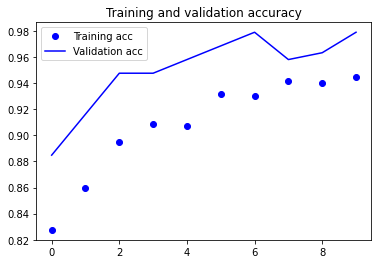

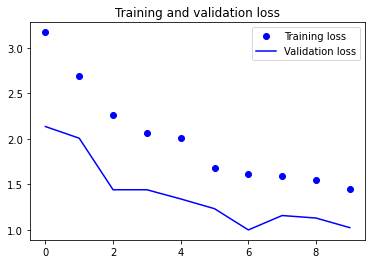

In [0]:
fighandle = showTrainHistory(hist_new1)

In [0]:
# Save entire model to a HDF5 file
model_new1.save_weights('model_new1_firemodel.h5')

# Recreate the exact same model, including weights and optimizer.
#model = tf.keras.models.load_model('my_model.h5')

In [0]:
model_new1.save('model_new1_firemodelsave.h5')

In [0]:
!rm -r saved_model

In [0]:
#!mkdir -p saved_model
model_new1.save('saved_model/model_new1_fire') 

INFO:tensorflow:Assets written to: saved_model/model_new1_fire/assets


INFO:tensorflow:Assets written to: saved_model/model_new1_fire/assets


In [0]:
!cp -r ./saved_model/ '/content/gdrive/My Drive/Colab Notebooks/'

# Convert the model to TF Lite

In [0]:
FIRE_SAVED_MODEL = './saved_model/model_new1_fire'
converter = tf.lite.TFLiteConverter.from_saved_model(FIRE_SAVED_MODEL)

In [0]:
converter.optimizations = [tf.lite.Optimize.DEFAULT] #Post-training quantization

In [0]:
tflite_quant_model = converter.convert()
open("convertedfire_model1.tflite", "wb").write(tflite_quant_model)

2372384

In [0]:
!ls

00910.jpg		     model_new1_firemodel.h5	  training_1
convertedfire_model1.tflite  model_new1_firemodelsave.h5  training_2
gdrive			     sample_data
labels.txt		     saved_model


In [0]:
!cp convertedfire_model1.tflite '/content/gdrive/My Drive/Colab Notebooks/'

#with data augumentation

In [0]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
IMAGE_SIZE = 220 #150
#train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

augumented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
Trainimage_path='/content/gdrive/My Drive/Developer/FireProject/FireVideo/binary_dataset/train'
Validimage_path='/content/gdrive/My Drive/Developer/FireProject/FireVideo/binary_dataset/validation'

validation_generator = test_datagen.flow_from_directory(
        directory = Validimage_path,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        class_mode='binary')


aug_train_generator = augumented_train_datagen.flow_from_directory(
        # This is the target directory
        Trainimage_path,
        # All images will be resized 
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 191 images belonging to 2 classes.
Found 1826 images belonging to 2 classes.


In [0]:
train_positive_dir = os.path.join(Trainimage_path, 'positives')  # directory with our training fire pictures
train_negative_dir = os.path.join(Trainimage_path, 'negatives')  # directory with our training no fire pictures
validation_positive_dir = os.path.join(Validimage_path, 'positives')  # directory with our validation fire pictures
validation_negative_dir = os.path.join(Validimage_path, 'negatives')  # directory with our validation no fire pictures

num_positive_tr = len(os.listdir(train_positive_dir))
num_negative_tr = len(os.listdir(train_negative_dir))

num_positive_val = len(os.listdir(validation_positive_dir))
num_negative_val = len(os.listdir(validation_negative_dir))

total_train = num_positive_tr + num_negative_tr
total_val = num_positive_val + num_negative_val

In [0]:
print('total training positive images:', num_positive_tr)
print('total training negative images:', num_negative_tr)

print('total validation positive images:', num_positive_val)
print('total validation negative images:', num_negative_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training positive images: 912
total training negative images: 914
total validation positive images: 93
total validation negative images: 98
--
Total training images: 1826
Total validation images: 191


In [0]:
#Visualize validation images
sample_validation_images, _ = next(validation_generator) #The next function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [0]:
print(sample_validation_images.shape)#1 batch 16 images

(16, 220, 220, 3)


In [0]:
# This function will plot images in the form of a grid with 1 row and num columns where images are placed in each column.
def plotImages(images_arr, num):
    fig, axes = plt.subplots(1, num, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

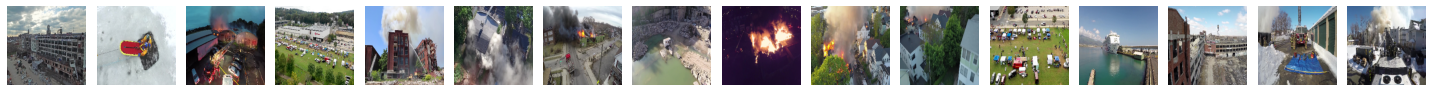

In [0]:
plotImages(sample_validation_images[:16], 16)

In [0]:
#Visualize training images
sample_train_images, _ = next(aug_train_generator) #The next function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

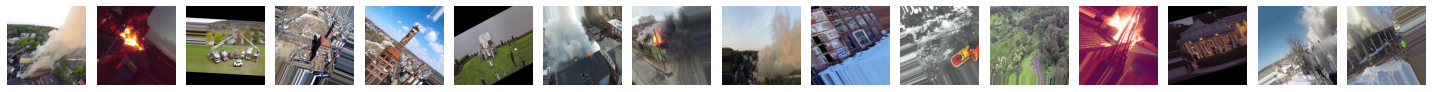

In [0]:
plotImages(sample_train_images[:16], 16)

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
#model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.03), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),#'binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [0]:
aug_train_generator.samples

1826

In [0]:
steps_per_epoch = aug_train_generator.samples // aug_train_generator.batch_size
val_steps_per_epoch = validation_generator.samples // validation_generator.batch_size

In [0]:
steps_per_epoch

114

In [0]:
total_train // 16

114

In [0]:
Epoch=10
history = model.fit(
      aug_train_generator,
      steps_per_epoch=steps_per_epoch, #the default NULL is equal to the number of samples in your dataset divided by the batch size
      epochs=Epoch,
      validation_data=validation_generator,#,
      validation_steps=val_steps_per_epoch
      )

model.save('Firemodel2.h5')

Epoch 1/10
114/114 [==============================] - 912s 8s/step - loss: 1.0439 - accuracy: 0.5685 - val_loss: 0.6581 - val_accuracy: 0.6857
Epoch 2/10
114/114 [==============================] - 66s 579ms/step - loss: 0.6612 - accuracy: 0.6826 - val_loss: 0.6295 - val_accuracy: 0.7314
Epoch 3/10
114/114 [==============================] - 66s 579ms/step - loss: 0.6330 - accuracy: 0.7608 - val_loss: 0.6113 - val_accuracy: 0.7829
Epoch 4/10
114/114 [==============================] - 64s 558ms/step - loss: 0.6345 - accuracy: 0.7597 - val_loss: 0.6030 - val_accuracy: 0.8114
Epoch 5/10
114/114 [==============================] - 63s 552ms/step - loss: 0.6240 - accuracy: 0.7707 - val_loss: 0.5870 - val_accuracy: 0.8743
Epoch 6/10
114/114 [==============================] - 62s 545ms/step - loss: 0.6200 - accuracy: 0.7796 - val_loss: 0.5914 - val_accuracy: 0.8800
Epoch 7/10
114/114 [==============================] - 62s 543ms/step - loss: 0.6144 - accuracy: 0.7867 - val_loss: 0.5868 - val_accu

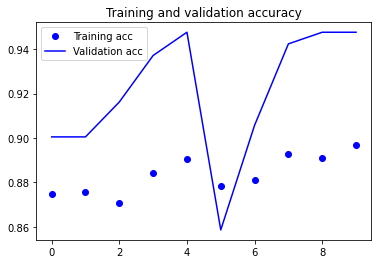

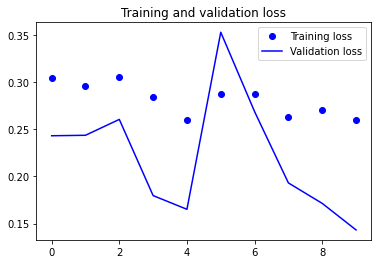

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
#Export model
export_dir = 'saved_model/1'
tf.saved_model.save(model2, export_dir)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/1/assets


In [0]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model1 = converter.convert()

In [0]:
tflite_model_file = 'model1.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model1)

In [0]:
!ls

00910.jpg  model1.tflite		     sample_data
gdrive	   myfirest_augumented_firemodel.h5  saved_model


#MobileNetv2 model

In [0]:
IMAGE_SIZE = 224
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.trainable = False #freeze the convolutional base created from the previous step and use that as a feature extractor,
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8028288   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,286,401
Trainable params: 8,028,417
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss=keras.losses.BinaryCrossentropy(), metrics=METRICS)

In [0]:
steps_per_epoch = aug_train_generator.samples // aug_train_generator.batch_size
val_steps_per_epoch = validation_generator.samples // validation_generator.batch_size

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
100/100 [==============================] - 986s 10s/step - loss: 0.6369 - tp: 732.0000 - fp: 63.0000 - tn: 742.0000 - fn: 63.0000 - accuracy: 0.9212 - precision: 0.9208 - recall: 0.9208 - auc: 0.9546 - val_loss: 0.2341 - val_tp: 362.0000 - val_fp: 8.0000 - val_tn: 406.0000 - val_fn: 20.0000 - val_accuracy: 0.9648 - val_precision: 0.9784 - val_recall: 0.9476 - val_auc: 0.9777
Epoch 2/10
100/100 [==============================] - 152s 2s/step - loss: 0.1415 - tp: 775.0000 - fp: 23.0000 - tn: 766.0000 - fn: 22.0000 - accuracy: 0.9716 - precision: 0.9712 - recall: 0.9724 - auc: 0.9916 - val_loss: 0.3352 - val_tp: 375.0000 - val_fp: 35.0000 - val_tn: 374.0000 - val_fn: 12.0000 - val_accuracy: 0.9410 - val_precision: 0.9146 - val_recall: 0.9690 - val_auc: 0.9709
Epoch 3/10
100/100 [==============================] - 54s 545ms/step - loss: 0.1127 - tp: 766.0000 - fp: 20.0000 - tn: 783.0000 - fn: 17.0000 - ac

# VGG Model

In [0]:
positiveerror/len(positive_predictions)#false negatives

0.15053763440860216